# Inception

### Kaggle score: --

### References:
1. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import gc

import cv2

### Run name

In [3]:
project_name = 'Digit_Recognizer'
step_name = 'Inception'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: Digit_Recognizer_Inception_20180226_174423


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\ref\Kaggle\digit-recognizer\input
log_path: D:\ref\Kaggle\digit-recognizer\log
model_path: D:\ref\Kaggle\digit-recognizer\model
output_path: D:\ref\Kaggle\digit-recognizer\output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

In [6]:
def show_data_images(rows, fig_column, y_data, *args):
    columns = len(args)
    figs, axes = plt.subplots(rows, columns, figsize=(rows, fig_column*columns))
    print(axes.shape)  
    for i, ax in enumerate(axes):
        y_data_str = ''
        if type(y_data) != type(None):
            y_data_str =  '_' + str(y_data[i])
        ax[0].set_title('28x28' + y_data_str)
        for j, arg in enumerate(args):
            ax[j].imshow(arg[i])

### Load data

In [7]:
train_file = os.path.join(input_path, 'train.csv')
test_file = os.path.join(input_path, 'test.csv')

In [8]:
%%time
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_data = raw_data[:,1:]
y_data = raw_data[:,0]

x_test = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')

describe(x_data)
describe(y_data)
describe(x_test)

(42000, 784) 0 255 112
(42000,) 0 9 96
(28000, 784) 0 255 112
Wall time: 27.9 s


In [9]:
x_data = x_data/255.
x_test = x_test/255.

describe(x_data)
describe(x_test)

x_data = x_data.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

describe(x_data)
describe(x_test)

(42000, 784) 0.0 1.0 263424112
(28000, 784) 0.0 1.0 175616112
(42000, 28, 28, 1) 0.0 1.0 144
(28000, 28, 28, 1) 0.0 1.0 144


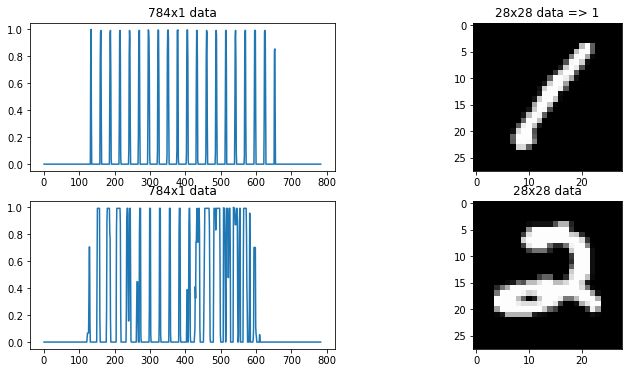

In [10]:
index = 0
fig, ax = plt.subplots(2, 2, figsize=(12,6))
ax[0, 0].plot(x_data[index].reshape(784,))
ax[0, 0].set_title('784x1 data')
ax[0, 1].imshow(x_data[index].reshape(28,28), cmap='gray')
ax[0, 1].set_title('28x28 data => ' + str(y_data[index]))
                 
ax[1, 0].plot(x_test[index].reshape(784,))
ax[1, 0].set_title('784x1 data')
ax[1, 1].imshow(x_test[index].reshape(28,28), cmap='gray')
ax[1, 1].set_title('28x28 data')

In [11]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
print(y_data[0])
y_data = to_categorical(y_data)
#example:
print(y_data[0])

Using TensorFlow backend.


1
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.05, random_state=2018)
describe(x_train)
describe(x_val)
describe(y_train)
describe(y_val)

(39900, 28, 28, 1) 0.0 1.0 250252944
(2100, 28, 28, 1) 0.0 1.0 13171344
(39900, 10) 0.0 1.0 3192112
(2100, 10) 0.0 1.0 168112


### Build model

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

In [14]:
def build_model():
    bn_model = 0
    p_activation = "relu"
    input_1 = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name="input")
    
    img_1 = Conv2D(128, kernel_size = (1,1), activation=p_activation, padding='same')(input_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2), padding='same') (img_1)
    img_1 = Dropout(0.25)(img_1)

    img_3 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same')(input_1)
    img_3 = BatchNormalization()(img_3)
    img_3 = AveragePooling2D((2,2), padding='same') (img_3)
    img_3 = Dropout(0.25)(img_3)
    
    img_5 = Conv2D(128, kernel_size = (5,5), activation=p_activation, padding='same')(input_1)
    img_5 = BatchNormalization()(img_5)
    img_5 = AveragePooling2D((2,2), padding='same') (img_5)
    img_5 = Dropout(0.25)(img_5)
    
    img_9 = Conv2D(128, kernel_size = (9,9), activation=p_activation, padding='same')(input_1)
    img_9 = BatchNormalization()(img_9)
    img_9 = AveragePooling2D((2,2), padding='same') (img_9)
    img_9 = Dropout(0.25)(img_9)

    concat_layer = (Concatenate()([img_1, img_3, img_5, img_9]))
#############################################################################################
    img_1 = Conv2D(128, kernel_size = (1,1), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2), padding='same') (img_1)
    img_1 = Dropout(0.25)(img_1)

    img_3 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_3 = BatchNormalization()(img_3)
    img_3 = AveragePooling2D((2,2), padding='same') (img_3)
    img_3 = Dropout(0.25)(img_3)
    
    img_5 = Conv2D(128, kernel_size = (5,5), activation=p_activation, padding='same')(concat_layer)
    img_5 = BatchNormalization()(img_5)
    img_5 = AveragePooling2D((2,2), padding='same') (img_5)
    img_5 = Dropout(0.25)(img_5)
    
    img_9 = Conv2D(128, kernel_size = (9,9), activation=p_activation, padding='same')(concat_layer)
    img_9 = BatchNormalization()(img_9)
    img_9 = AveragePooling2D((2,2), padding='same') (img_9)
    img_9 = Dropout(0.25)(img_9)

    concat_layer = (Concatenate()([img_1, img_3, img_5, img_9]))
#############################################################################################
    img_1 = Conv2D(128, kernel_size = (1,1), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2), padding='same') (img_1)
    img_1 = Dropout(0.25)(img_1)

    img_3 = Conv2D(128, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_3 = BatchNormalization()(img_3)
    img_3 = AveragePooling2D((2,2), padding='same') (img_3)
    img_3 = Dropout(0.25)(img_3)
    
    img_5 = Conv2D(128, kernel_size = (5,5), activation=p_activation, padding='same')(concat_layer)
    img_5 = BatchNormalization()(img_5)
    img_5 = AveragePooling2D((2,2), padding='same') (img_5)
    img_5 = Dropout(0.25)(img_5)
    
    img_9 = Conv2D(128, kernel_size = (9,9), activation=p_activation, padding='same')(concat_layer)
    img_9 = BatchNormalization()(img_9)
    img_9 = AveragePooling2D((2,2), padding='same') (img_9)
    img_9 = Dropout(0.25)(img_9)

    concat_layer = (Concatenate()([img_1, img_3, img_5, img_9]))
#############################################################################################
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2)) (img_1)
    img_1 = Dropout(0.25)(img_1)
#############################################################################################
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(512, kernel_size = (3,3), activation=p_activation, padding='same')(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = AveragePooling2D((2,2)) (img_1)
    img_1 = Dropout(0.25)(img_1)
#############################################################################################

    img_1 = GlobalAveragePooling2D() (img_1)

    dense_ayer = Dense(4096, activation=p_activation)(img_1)
#     dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.25)(dense_ayer)
    dense_ayer = Dense(4096, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.25)(dense_ayer)
    dense_ayer = Dense(128, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.25)(dense_ayer)
    output = Dense(10, activation='softmax')(dense_ayer)

    model = Model(input_1, output)
    
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
    return model

In [15]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  256         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  1280        input[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 128)  3328        input[0][0]                      
__________________________________________________________________________________________________
conv2d_4 (

In [16]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [17]:
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** x)

def get_lr(x):
    lr = round(3e-4 * 0.9 ** x, 12)
    if lr < 1e-12:
        lr = 1e-12
    print('%.12f' % lr, end=' ')
    return lr
annealer = LearningRateScheduler(get_lr)

# log_dir = os.path.join(log_path, run_name)
# print('log_dir:' + log_dir)
# tensorBoard = TensorBoard(log_dir=log_dir)

callbacks = [annealer]

In [18]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    rotation_range = 20,
    height_shift_range = 0.1,
    width_shift_range = 0.3
)

val_datagen = ImageDataGenerator()

In [19]:
%%time
batch_size = 128
steps_per_epoch = x_train.shape[0] / batch_size
hist = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size, seed=2018),
    steps_per_epoch=steps_per_epoch,
    epochs=300, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=callbacks,
    max_queue_size=256,
    workers=32,
    validation_steps=1000,
    validation_data=val_datagen.flow(x_val, y_val, batch_size=32, seed=2018)
)

0.000300000000 Epoch 1/300
312/311 [==============================] - 87s 280ms/step - loss: 0.5759 - acc: 0.8147 - val_loss: 3.7400 - val_acc: 0.1005
0.000270000000 Epoch 2/300
312/311 [==============================] - 83s 267ms/step - loss: 0.1835 - acc: 0.9502 - val_loss: 0.5320 - val_acc: 0.8543
0.000243000000 Epoch 3/300
312/311 [==============================] - 83s 267ms/step - loss: 0.1227 - acc: 0.9655 - val_loss: 0.0543 - val_acc: 0.9871
0.000218700000 Epoch 4/300
312/311 [==============================] - 83s 267ms/step - loss: 0.1044 - acc: 0.9729 - val_loss: 0.0521 - val_acc: 0.9829
0.000196830000 Epoch 5/300
312/311 [==============================] - 83s 267ms/step - loss: 0.0914 - acc: 0.9750 - val_loss: 0.0411 - val_acc: 0.9881
0.000177147000 Epoch 6/300
312/311 [==============================] - 83s 267ms/step - loss: 0.0829 - acc: 0.9771 - val_loss: 0.0460 - val_acc: 0.9871
0.000159432300 Epoch 7/300
312/311 [==============================] - 83s 267ms/step - loss: 0

0.000001014418 Epoch 55/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0196 - acc: 0.9941 - val_loss: 0.0242 - val_acc: 0.9952
0.000000912976 Epoch 56/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0191 - acc: 0.9943 - val_loss: 0.0238 - val_acc: 0.9948
0.000000821678 Epoch 57/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0190 - acc: 0.9941 - val_loss: 0.0239 - val_acc: 0.9952
0.000000739510 Epoch 58/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0209 - acc: 0.9937 - val_loss: 0.0237 - val_acc: 0.9948
0.000000665559 Epoch 59/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0238 - val_acc: 0.9952
0.000000599003 Epoch 60/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0169 - acc: 0.9945 - val_loss: 0.0237 - val_acc: 0.9952
0.000000539103 Epoch 61/300
312/311 [==============================] - 83s 265ms/step - 

0.000000003430 Epoch 109/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0179 - acc: 0.9947 - val_loss: 0.0239 - val_acc: 0.9952
0.000000003087 Epoch 110/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0167 - acc: 0.9949 - val_loss: 0.0239 - val_acc: 0.9952
0.000000002778 Epoch 111/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0201 - acc: 0.9943 - val_loss: 0.0239 - val_acc: 0.9952
0.000000002501 Epoch 112/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0182 - acc: 0.9946 - val_loss: 0.0238 - val_acc: 0.9952
0.000000002251 Epoch 113/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0201 - acc: 0.9939 - val_loss: 0.0239 - val_acc: 0.9957
0.000000002025 Epoch 114/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0187 - acc: 0.9939 - val_loss: 0.0237 - val_acc: 0.9952
0.000000001823 Epoch 115/300
312/311 [==============================] - 83s 265ms/

312/311 [==============================] - 83s 265ms/step - loss: 0.0178 - acc: 0.9945 - val_loss: 0.0240 - val_acc: 0.9952
0.000000000012 Epoch 163/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0193 - acc: 0.9942 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000010 Epoch 164/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0193 - acc: 0.9943 - val_loss: 0.0240 - val_acc: 0.9952
0.000000000009 Epoch 165/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0190 - acc: 0.9946 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000008 Epoch 166/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0180 - acc: 0.9948 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000008 Epoch 167/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0179 - acc: 0.9944 - val_loss: 0.0238 - val_acc: 0.9952
0.000000000007 Epoch 168/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0172 - acc: 0.

0.000000000001 Epoch 216/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0181 - acc: 0.9946 - val_loss: 0.0239 - val_acc: 0.9948
0.000000000001 Epoch 217/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0195 - acc: 0.9942 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000001 Epoch 218/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0181 - acc: 0.9947 - val_loss: 0.0238 - val_acc: 0.9952
0.000000000001 Epoch 219/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0173 - acc: 0.9951 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000001 Epoch 220/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0186 - acc: 0.9946 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000001 Epoch 221/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0175 - acc: 0.9945 - val_loss: 0.0241 - val_acc: 0.9952
0.000000000001 Epoch 222/300
312/311 [==============================] - 83s 265ms/

312/311 [==============================] - 83s 265ms/step - loss: 0.0188 - acc: 0.9943 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000001 Epoch 270/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0173 - acc: 0.9948 - val_loss: 0.0240 - val_acc: 0.9948
0.000000000001 Epoch 271/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0173 - acc: 0.9943 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000001 Epoch 272/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0171 - acc: 0.9949 - val_loss: 0.0239 - val_acc: 0.9957
0.000000000001 Epoch 273/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0191 - acc: 0.9940 - val_loss: 0.0238 - val_acc: 0.9952
0.000000000001 Epoch 274/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0190 - acc: 0.9940 - val_loss: 0.0239 - val_acc: 0.9952
0.000000000001 Epoch 275/300
312/311 [==============================] - 83s 265ms/step - loss: 0.0189 - acc: 0.

In [20]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0239, final accuracy: 0.9948


In [21]:
final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

Digit_Recognizer_Inception_20180226_174423_9947


In [22]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


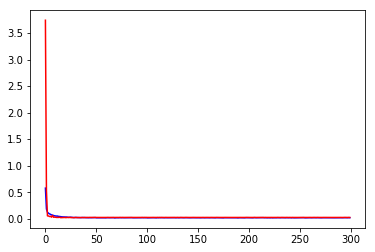

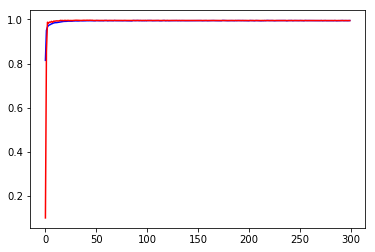

In [23]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [24]:
saveModel(model, run_name_acc)

In [25]:
# y_hat = model.predict(x_val)
# y_pred = np.argmax(y_hat, axis=1)
# y_true = np.argmax(y_val, axis=1)
# cm = confusion_matrix(y_true, y_pred)
# print(cm)

accuracy_score: 0.994761904762
[[198   0   0   0   0   1   0   0   0   0]
 [  0 232   0   0   0   0   0   0   0   0]
 [  0   0 205   0   0   0   0   0   0   0]
 [  0   0   0 220   0   0   0   1   1   0]
 [  0   0   0   0 213   0   0   1   0   1]
 [  0   0   0   0   0 180   0   0   0   0]
 [  0   1   0   0   0   0 183   0   0   0]
 [  0   1   0   0   0   0   0 233   0   0]
 [  0   0   0   1   0   0   0   0 210   0]
 [  0   0   0   0   2   0   0   0   1 215]]
count: 11
(11,)


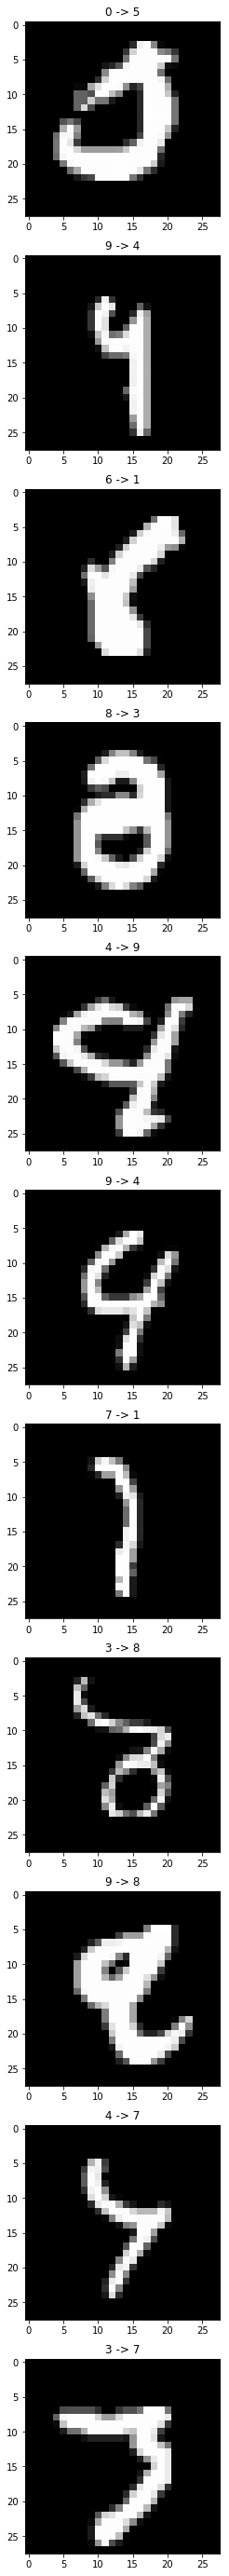

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score
def show_diffs(model, x_data, y_data, labels):
    y_hat = model.predict(x_data)
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_data, axis=1)
    print('accuracy_score: %s' % accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels)
    print(cm)
    indexes = []
    diffs = []
    for i, p in enumerate(zip(y_true, y_pred)):
        if p[0] != p[1]:
            indexes.append(i)
            diffs.append(p)
    count = len(indexes)
    print('count: %s' % count)
    figs, axes = plt.subplots(count, 1, figsize=(count,50))
    print(axes.shape)
    for i, p in enumerate(diffs):
        axes[i].imshow(x_val[indexes[i]].reshape(28, 28), cmap='gray')
        axes[i].set_title('%s -> %s' % (p[0], p[1]))
        
show_diffs(model, x_val, y_val, labels=list(range(0, 10)))

## Predict

In [27]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\ref\Kaggle\digit-recognizer\output\Digit_Recognizer_Inception_20180226_174423_9947.csv


In [28]:
y_hat = model.predict(x_test, batch_size=64)

In [29]:
y_pred = np.argmax(y_hat,axis=1)

In [30]:
with open(pred_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

In [31]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 24953.75 s
Done!


In [32]:
print(run_name_acc)

Digit_Recognizer_Inception_20180226_174423_9947
